# Assign land cover to FPA FOD wildfires
- Use MODIS land cover data for the best guess of land cover type burned by a given FPA-FOD wildfire. 
- Assume spherical burn scar around FPA FOD fire lat lon location. Use that scar to estimate the types of land cover burned by a fire. 
- The land cover data are 0.5 x 0.5 km, so many of the fires in FPA FOD will essentially have point estimate land cover types given the size of the grid. 


Consider impact of going from a burn area estimate on a slope to a flat world for the modis burn area. This may require using overlap only for assigning proportions of the assigned burn area value.  

In [1]:
area_of_modis_cell = (0.5*1000.)**2
print str(area_of_modis_cell) + " m2: area of 0.5 x 0.5 degree MODIS grid cell at equator"

m2_per_acre = 4046.86 # m2/acres
acres_per_cell = area_of_modis_cell / m2_per_acre

print str(acres_per_cell) + ": acres per modis land cover grid cell"

250000.0 m2: area of 0.5 x 0.5 degree MODIS grid cell at equator
61.7762907538: acres per modis land cover grid cell


| Value        | Label          |
| -------------|:-------------|
|0 | Water|
|1|Evergreen Needleleaf forest|
|2|Evergreen Broadleaf forest|
|3|Deciduous Needleleaf forest|
|4|Deciduous Broadleaf forest|
|5|Mixed forest|
|6|Closed shrublands|
|7|Open shrublands|
|8|Woody savannas|
|9|Savannas|
|10|Grasslands|
|11|Permanent wetlands|
|12|Croplands|
|13|Urban and built-up|
|14|Cropland/Natural vegetation mosaic|
|15|Snow and ice|
|16|Barren or sparsely vegetated|

This means that the 0.5 km modis land cover can resolve sub wildfire burn scar land cover types, i.e. it is and should be possible to estimate the different land covers that are consumed by large wildfires. 

### Get the MODIS land cover data loaded into the workspace

In [2]:
import gdal
import os
import numpy as np
from matplotlib import pylab as plt
%matplotlib inline

dataDir = os.path.join("..", "..", "metSpreadData", "GIS")
f = os.path.join(dataDir, "LCType.tif")
gtif = gdal.Open( f )
LC_data = np.array(gtif.GetRasterBand(1).ReadAsArray())

print "Shape of the LC data:"
print LC_data.shape

# Get the coordinates 
width = gtif.RasterXSize
height = gtif.RasterYSize
gt = gtif.GetGeoTransform()

print width
print height
print type(gt)

minx = gt[0]
miny = gt[3] + width*gt[4] + height*gt[5] 
maxx = gt[0] + width*gt[1] + height*gt[2]
maxy = gt[3] 

print "Printing the coordinate limits as defined here:"
print "minx " + str(minx)
print "maxx " + str(maxx)
print "miny " + str(miny)
print "maxy " + str(maxy)

print "working on getting unique values in large 2D array...."
print "Unique land cover values array: " + str(np.unique(LC_data))

# Logically speaking, the data should span the length of the min and max coord values
# by the number of dim size. 
# TODO: Read the documentation to understand if these coords represent grid centers or 
# TODO: corners. 
LC_x = np.linspace(minx, maxx, LC_data.shape[1])
LC_y = np.linspace(maxy, miny, LC_data.shape[0])

Shape of the LC data:
(43200, 86400)
86400
43200
<type 'tuple'>
Printing the coordinate limits as defined here:
minx -179.999999998
maxx 180.000000002
miny -90.0000000081
maxy 89.9999999919
working on getting unique values in large 2D array....
Unique land cover values array: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


#### Make up fire location and test functionality of overlap methods below

Grid spacing in x 0.004166714892562595
Grid spacing in y 0.004166763119542338
Fire location and area
-119.176894
46.487794
4046860.0
fire_rad_deg: 0.012111216501487358


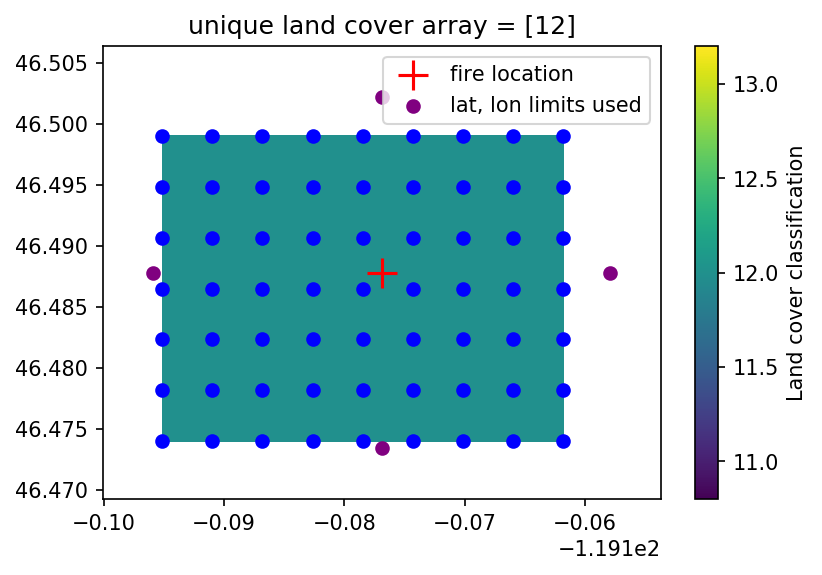

The raw subset array values
[[12 12 12 12 12 12 12 12 12]
 [12 12 12 12 12 12 12 12 12]
 [12 12 12 12 12 12 12 12 12]
 [12 12 12 12 12 12 12 12 12]
 [12 12 12 12 12 12 12 12 12]
 [12 12 12 12 12 12 12 12 12]
 [12 12 12 12 12 12 12 12 12]]
(7, 9)


In [27]:
# In order to subset the land cover grid around a fire's location, need to 
# know the width of the grid in deg units. 
LC_grid_dx = np.max(np.diff(LC_x))
LC_grid_dy = np.max(np.abs(np.diff(LC_y)))

print "Grid spacing in x " + str(LC_grid_dx)
print "Grid spacing in y " + str(LC_grid_dy)

# hypothetical 1000 acre wildfire. These will come from FPA FOD
# #rainier_summit = [-121.7586, 46.85449]
fire_size_acres = 1000.
fire_lon = -119.176894  
fire_lat =  46.487794 

m2_per_acres = 4046.86
fire_area_m2 = fire_size_acres * m2_per_acres

print "Fire location and area"
print fire_lon
print fire_lat
print fire_area_m2

# Assuming the fire area is a circle, calculate radius from area
# NOTE: Area needs to be in m**2
fire_rad_m = np.sqrt(fire_area_m2/np.pi)

# Subset the LC grid needed to encompas this circle. Create spatial extents
# using local meters per degree values in the x and y directions. 
# NOTE: The coords of LC_grid units are degrees lon and lat. 
m_per_deg_lat = (111.*1000.) # ~111 km per deg and 1000 meter per km
m_per_deg_lon = (111.*1000.) * np.cos(fire_lat * np.pi/180.) # 0 at pole, 90 deg N. 
extend_dy_deg    = fire_rad_m / m_per_deg_lat # degrees lat
extend_dx_deg    = fire_rad_m / m_per_deg_lon # degrees lon 

# Fire radius needs to be expressed in terms of degrees for polygon creation
fire_rad_deg = fire_rad_m / np.mean([m_per_deg_lat, m_per_deg_lon])
print "fire_rad_deg: " + str(fire_rad_deg)

# Establish LC_grid extent where overlap calculations are needed
# Add one LC_grid box width to make sure the circle is covered. 
minLat = fire_lat - (extend_dy_deg + LC_grid_dy) 
maxLat = fire_lat + (extend_dy_deg + LC_grid_dy)
minLon = fire_lon - (extend_dx_deg + LC_grid_dx)
maxLon = fire_lon + (extend_dx_deg + LC_grid_dx)

# Mask these extends on the LC coordinates and grid
lonIndex = np.where( ( (LC_x >= minLon) & (LC_x <= maxLon)) )[0]
latIndex = np.where( ( (LC_y >= minLat) & (LC_y <= maxLat) ) )[0]
LC_x_subset = LC_x[lonIndex]
LC_y_subset = LC_y[latIndex]
LC_subset   = LC_data[np.ix_(latIndex, lonIndex)]

# Get a local dx dy for this subset of grid boxes
LC_subset_dx = np.max(np.diff(LC_x_subset))
LC_subset_dy = np.max(np.abs(np.diff(LC_y_subset)))

# Make grid subset into an shapely polygon 
plt.figure(dpi=150)
plt.pcolor(LC_x_subset, LC_y_subset, LC_subset)
plt.xlim([minLon-LC_grid_dx, maxLon+LC_grid_dx])
plt.ylim([minLat-LC_grid_dy, maxLat+LC_grid_dy])
plt.colorbar(label="Land cover classification")
plt.title("unique land cover array = " + str(np.unique(LC_subset)) )
plt.scatter(fire_lon, fire_lat, color="red", marker="+", label="fire location", s=200)
# Add limits used to subset LC grid 
plt.scatter(fire_lon, maxLat, color="purple")
plt.scatter(fire_lon, minLat, color="purple")
plt.scatter(minLon, fire_lat, color="purple")
plt.scatter(maxLon, fire_lat, color="purple", label="lat, lon limits used")
for i in range(len(LC_x_subset)):
    for j in range(len(LC_y_subset)):
        plt.scatter(LC_x_subset[i], LC_y_subset[j], color="blue")
plt.legend(loc=0)
plt.show()

print "The raw subset array values"
print LC_subset
print LC_subset.shape

### Develop funtion to determine overlap
on plotting shapes: https://gis.stackexchange.com/questions/197945/geopandas-polygon-to-matplotlib-patches-polygon-conversion

on overlapping shapes: https://stackoverflow.com/questions/14697442/faster-way-of-polygon-intersection-with-shapely/14804366#14804366

---------------------------------------------------
Initial Fire Circle Area: 0.000460073841749
---------------------------------------------------
ncolumn: 9
nrow: 7
length of LC_cover list: 63
For loop complete
GeoDataFrames created


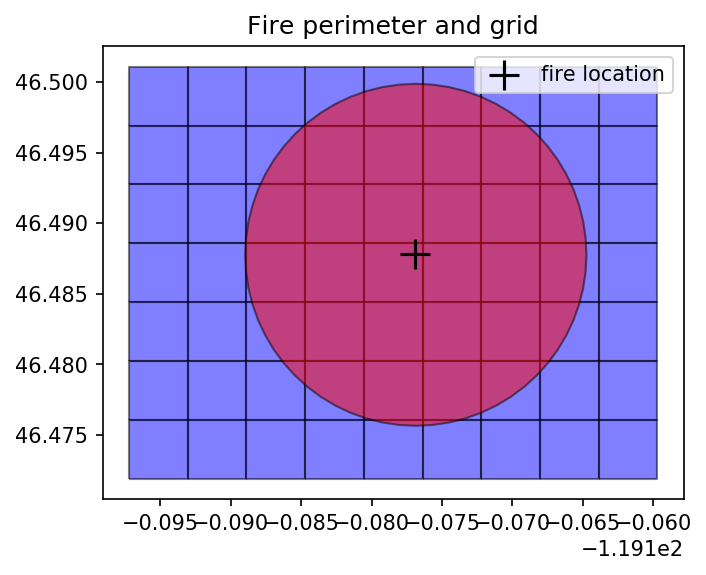

In [44]:
# http://geopandas.org/set_operations.html
from shapely.geometry import Polygon, Point
import geopandas
import pandas as pd

# Make fire a circle shapely polygon object 
fire_poly = Point(fire_lon, fire_lat).buffer(fire_rad_deg)

print "---------------------------------------------------"
print "Initial Fire Circle Area: " + str(fire_poly.area)
print "---------------------------------------------------"

# NOTE: The definition of the polygon corners depends on whether the LC_grid_coords
# NOTE: represent grid corners or grid centers. 
# TODO: Retain land cover information here. 
ncolumn = len(LC_x_subset)
nrow = len(LC_y_subset)
print "ncolumn: " + str(ncolumn)
print "nrow: " + str(nrow)

count = 0
LC_grid_polygon_list = [None] * (ncolumn * nrow)
LC_cover = [None] * (ncolumn * nrow)
print "length of LC_cover list: " + str(len(LC_cover))
for i in range(ncolumn):
    for j in range(nrow):
        # Get land cover for this grid box
        LC_cover[count] = LC_subset[j, i]
        # Make the grid box into a Polygon
        x0 = LC_x_subset[i] - LC_subset_dx/2.
        x1 = LC_x_subset[i] + LC_subset_dx/2.
        y0 = LC_y_subset[j] - LC_subset_dy/2.
        y1 = LC_y_subset[j] + LC_subset_dy/2.
        LC_grid_polygon_list[count]  = Polygon([(x0, y0), (x1, y0), (x1, y1), (x0, y1)])
        count = count + 1 # Advance the count of created polygons

print "For loop complete"
        
# Create GeoSeries of local grid and fire
grid_polys = geopandas.GeoSeries(LC_grid_polygon_list)
fire_polys  = geopandas.GeoSeries(fire_poly)
# Create GeoDataFrame, which have desirable properties and methods
df1 = geopandas.GeoDataFrame({'geometry': grid_polys, 'grid_LC_val':LC_cover})
df2 = geopandas.GeoDataFrame({'geometry': fire_polys, 'Fire':"FireName"})

print "GeoDataFrames created"

# TODO: why is there so much extra grid boxes surrounding the fire circle? 
# Show the grid and fire
fig, ax = plt.subplots(1, 1, dpi=150, figsize=(5,4))
df1.plot(ax=ax, color='blue' ,alpha=0.5, edgecolor='black');
df2.plot(ax=ax, color='red', alpha=0.5, edgecolor='black');
plt.scatter(fire_lon, fire_lat, color="black",marker="+", label="fire location", s=200)
plt.title("Fire perimeter and grid")
plt.legend()
plt.show()


100.00000000000294
Max percent of circle area for a single gridcell: 3.7736798679378536
Min percent of circle area for a single gridcell: 4.213486659386135e-13
Sum of all percent overlap values: 100.00000000000294


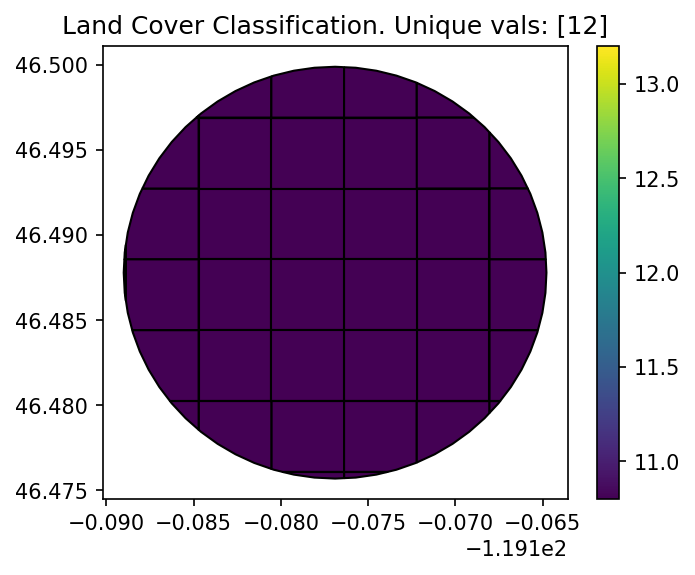

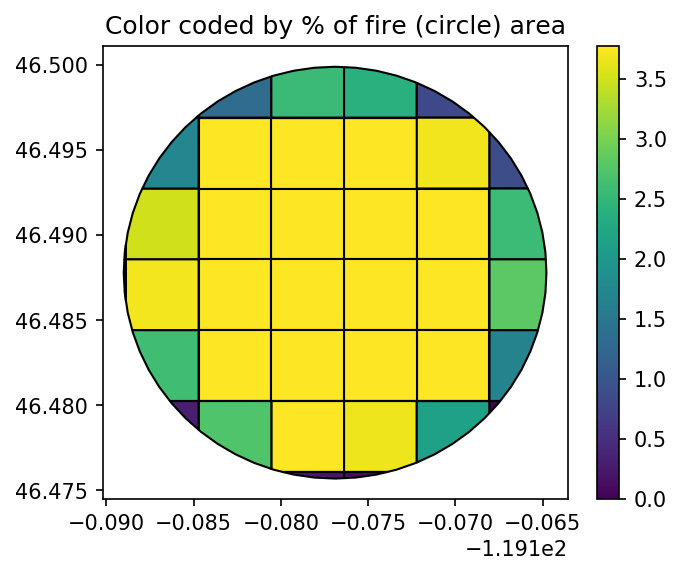

,grid_LC_val,Fire,geometry,overlap_area,percent_of_fire_area
0,12,FireName,"POLYGON ((-119.1722126393459 46.492742879484, ...",3.773680e-02,3.773680e+00
1,12,FireName,"POLYGON ((-119.1763793542384 46.492742879484, ...",3.773680e-02,3.773680e+00
2,12,FireName,"POLYGON ((-119.188879498916 46.4894354723921, ...",3.497897e-02,3.497897e+00
3,12,FireName,"POLYGON ((-119.1879347384873 46.492742879484, ...",1.734860e-02,1.734860e+00
4,12,FireName,POLYGON ((-119.1848491948892 46.49690964260351...,4.213487e-15,4.213487e-13
5,12,FireName,POLYGON ((-119.1848491948892 46.49690964260353...,1.832884e-05,1.832884e-03
6,12,FireName,"POLYGON ((-119.1847127840235 46.4970332782055,...",1.314641e-02,1.314641e+00
7,12,FireName,POLYGON ((-119.1805460691309 46.49933491813493...,2.556173e-02,2.556173e+00
8,12,FireName,POLYGON ((-119.1763793542384 46.49987993357647...,2.390188e-02,2.390188e+00
9,12,FireName,POLYGON ((-119.1722126393459 46.49896126547065...,8.151083e-03,8.151083e-01


In [52]:
# returns only the geometries that are contained by both GeoDataFrames
res_intersection = geopandas.overlay(df1, df2, how='intersection')

# Add the overlapping area to this intersection dataframe 
res_intersection['overlap_area'] = pd.Series(res_intersection.area/fire_poly.area, index=res_intersection.index)

# Append Percent Overlap information to the intersection DataFrame 
res_intersection['percent_of_fire_area'] = pd.Series(res_intersection.area/fire_poly.area*100., 
                                                     index=res_intersection.index)

print np.sum(res_intersection['percent_of_fire_area'])

# TODO: Estimate area error. What area is given by the polygon circle? How far off
# TODO: from original? 
#(fire_poly.area * m_per_deg * m_per_deg ) - fire_area
print "Max percent of circle area for a single gridcell: " + str(np.max(res_intersection['percent_of_fire_area']))
print "Min percent of circle area for a single gridcell: " + str(np.min(res_intersection['percent_of_fire_area']))
print "Sum of all percent overlap values: " + str(np.sum(res_intersection['percent_of_fire_area']))

# TODO: WHY IS THE GRID ROTATED?
fig, ax = plt.subplots(1, 1, dpi=150, figsize=(5,4))
res_intersection.plot(column='grid_LC_val', edgecolor='black', legend=True, ax=ax)
plt.title("Land Cover Classification. Unique vals: " + str(np.unique(LC_subset)))
plt.show()

fig, ax = plt.subplots(1, 1, dpi=150, figsize=(5,4))
res_intersection.plot(column='percent_of_fire_area', edgecolor='black', legend=True, ax=ax)
plt.title("Color coded by % of fire (circle) area")
plt.show()

# Look at the dataframe
res_intersection

# Present the differences from point estimates

In [ ]:
from shapely.ops import cascaded_union
from rtree import index
idx = index.Index()

# Populate R-tree index with bounds of grid cells
for pos, cell in enumerate(grid_cells):
    # assuming cell is a shapely object
    idx.insert(pos, cell.bounds)

# Loop through each Shapely polygon
for poly in polygons:
    # Merge cells that have overlapping bounding boxes
    merged_cells = cascaded_union([grid_cells[pos] for pos in idx.intersection(poly.bounds)])
    # Now do actual intersection
    print poly.intersection(merged_cells).area

In [ ]:

from shapely import geometry
from descartes import PolygonPatch

fire_circle = geometry.Point(1,1).buffer(1)


# Make some polygon, will enventualy be all the grid boxes in LC_subset 
polygon1 = geometry.Polygon([[0, 0], [1, 0], [1, 1], [0, 1]])
polygon2 = geometry.Polygon([[1, 0], [1, 1], [2, 1], [2, 0]])
polygon3 = geometry.Polygon([[0, 1], [0, 2], [1, 2], [1, 1]])
polygon4 = geometry.Polygon([[1, 1], [1, 2], [2, 2], [2, 1]])

polygons = [polygon1, polygon2, polygon3, polygon4, fire_circle]


# Find a way to get the area, and highlight, the overlapping part of this figure. 

fig = plt.figure(dpi=150) 
ax = fig.gca() 
ax.add_patch(PolygonPatch(polygon1, fc="blue", ec="red", alpha=0.3))
ax.add_patch(PolygonPatch(polygon2, fc="green", ec="red", alpha=0.3))
ax.add_patch(PolygonPatch(polygon3, fc="red", ec="red", alpha=0.3))
ax.add_patch(PolygonPatch(polygon4, fc="purple", ec="red", alpha=0.3))


ax.add_patch(PolygonPatch(fire_circle, fc="yellow", ec="black", alpha=0.1))
ax.axis('scaled')
plt.title("Yeah plotting shapes!")
plt.xlabel("some x coord")
plt.xlabel("some y coord")
plt.show()
